Initial implementation of https://arxiv.org/pdf/2410.10103

Attempting to reproduce Coupled-Rossler analysis, with deep learning extension to learn the coordinate transforms.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import numpy as np
import torch
import torchdiffeq

import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

from kausal.generator import coupled_rossler
from kausal.koopman import *

# Generate dynamics 
In particular, trying to replicate Fig 1b.
Since the IC is not defned in the paper, tried to approximate i.e., eye-ball from the subfigure

### Specify parameters, ICs, timestepping

In [3]:
# Time span
t0, t1 = 0.0, 10.0
dt = 0.01
steps = int((t1 - t0) / dt)

# Parameters
phi1, phi2 = 1.0, 1.0  # Frequencies
a, b, d = 0.2, 0.2, 5.7  # Rössler parameters

# Initial condition (eye-ball from the paper)
initial_state = torch.tensor([1.0, -2.0, 0.0, 0.0, 0.0, 0.0])

# Coupling coefficients 
# (causal direction: Omega 2 --> Omega 1; but NOT Omega 1 --> Omega 2)
c2 = 0


### Integrate forward

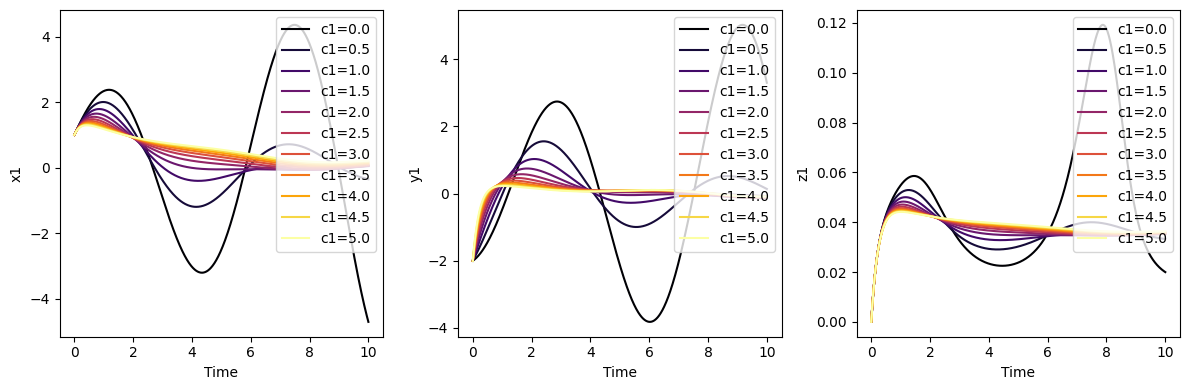

In [4]:
# Integration
solver = torchdiffeq.odeint

# Create figure
f, ax = plt.subplots(1, 3, figsize=(12, 4))

# Generate color map
c1_values = torch.linspace(0, 5, 11)  # Coupling strength values
colors = cm.inferno(np.linspace(0, 1, len(c1_values)))  # Inferno colormap

def solve_dynamics(t0, t1, dt, initial_state, params):
    """Solve dynamics"""
    t = torch.linspace(t0, t1, int((t1 - t0) / dt))
    dynamics = lambda t, state: coupled_rossler(t, state, params)
    
    solution = solver(
        dynamics,
        initial_state,
        t,
        method = 'dopri5',
        options = {'max_num_steps': 100000}
    )
    return t, solution

# Iterate over coupling values and solve the system
for c1, color in zip(c1_values, colors):
    params = (phi1, phi2, a, b, d, c1, c2)

    # Solve the system
    t, solution = solve_dynamics(t0, t1, dt, initial_state, params)

    # Extract results (divided into omega_1, omega_2)
    omega_1 = solution.T[:3]
    omega_2 = solution.T[3:]

    # Plot the results
    ax[0].plot(t.numpy(), omega_1[0].numpy(), label=f"c1={c1:.1f}", color=color)
    ax[1].plot(t.numpy(), omega_1[1].numpy(), label=f"c1={c1:.1f}", color=color)
    ax[2].plot(t.numpy(), omega_1[2].numpy(), label=f"c1={c1:.1f}", color=color)

# Add labels and legends
for i, var in enumerate(["x1", "y1", "z1"]):
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(var)
    ax[i].legend(loc="upper right")

plt.tight_layout()
plt.show();


# Causal Koopman

### Causal dependence with increasing shifts

We evaluate the temporal dependence, primarily to reproduce Figure 2.

In [5]:
# Integration
t0, t1 = 0.0, 40.0
dt = 0.01
steps = int((t1 - t0) / dt)
phi1, phi2 = 1.0, 1.0  # Frequencies
a, b, d = 0.2, 0.2, 5.7  # Rössler parameters
c1, c2 = 0.5, 0 # Coupling term
params = (phi1, phi2, a, b, d, c1, c2)

# Solve the system
t, solution = solve_dynamics(t0, t1, dt, initial_state, params)

# Extract results (divided into omega_1, omega_2)
omega_1 = solution.T[:3]
omega_2 = solution.T[3:]


100%|██████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:25<00:00,  1.55it/s]


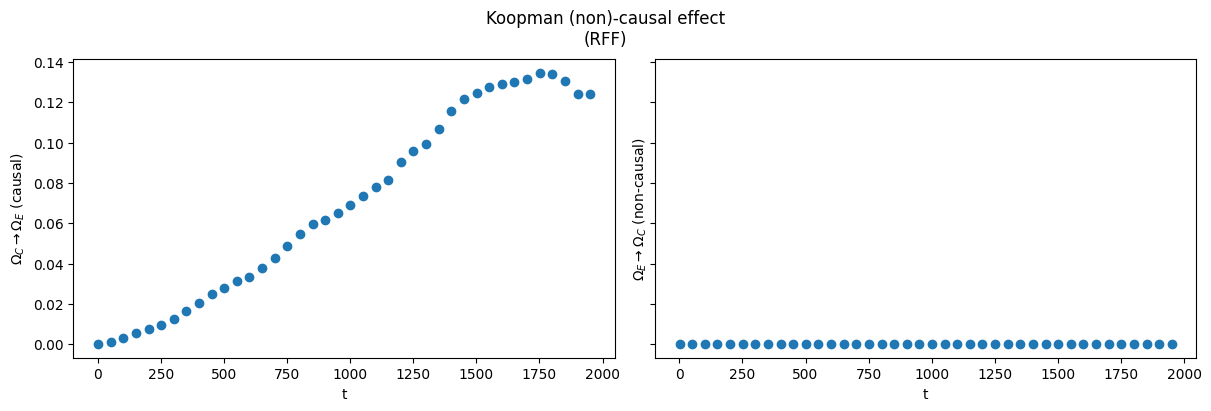

In [6]:
# Causal shifts
time_shifts = torch.arange(1, 2000, 50)
losses = {'causal': [], 'non_causal': []}

for t in tqdm(time_shifts):

    ## 1. Causal loss
    causal_loss, _, _ = compute_causal_loss(
        cause = omega_2, 
        effect = omega_1,
        t = t
    )

    ## 2. Non-causal loss
    non_causal_loss, _, _ = compute_causal_loss(
        cause = omega_1,
        effect = omega_2,
        t = t
    )

    losses['causal'].append(causal_loss)
    losses['non_causal'].append(non_causal_loss)

# Plot
f, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)
ax[0].scatter(time_shifts, losses['causal'])
ax[0].set_xlabel('t')
ax[0].set_ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

ax[1].scatter(time_shifts, losses['non_causal'])
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$\Omega_E \rightarrow \Omega_C$ (non-causal)')

f.suptitle('Koopman (non)-causal effect\n(RFF)')
plt.show();


### Conditioning forecasting
This is primarily to reproduce the algorithms introduced in Part IV section B, and Figure 4.

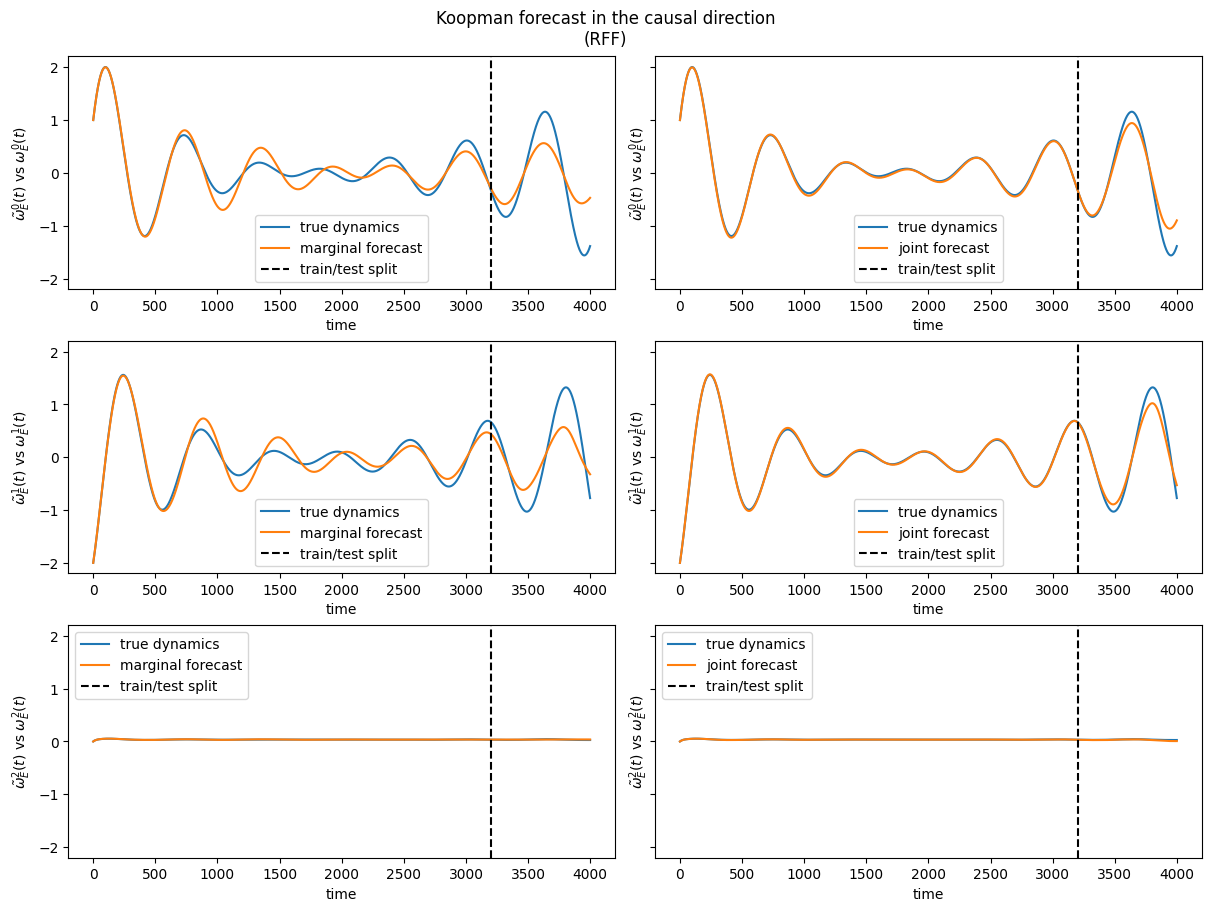

In [7]:
# Conditional inference (causal)
# Expected behavior: imperfect match in the marginal model, but perfect in joint.
cause = omega_2
effect = omega_1
n_train = int(0.8 * steps)

omega_marginal, omega_joint = conditional_forecasting(
    cause = cause, 
    effect = effect, 
    n_train = n_train, 
    t = 1
)

# Plot
f, ax = plt.subplots(len(effect), 2, figsize=(12, 3 * len(effect)), sharey=True, constrained_layout=True)

for param_id in range(effect.shape[0]):
    # Left subplot: marginal forecast
    ax[param_id, 0].plot(effect[param_id], label='true dynamics')
    ax[param_id, 0].plot(omega_marginal[param_id], label='marginal forecast')
    ax[param_id, 0].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 0].set_xlabel('time')
    ax[param_id, 0].set_ylabel(rf'$\tilde{{\omega}}_E^{{{param_id}}}(t)$ vs $\omega_E^{{{param_id}}}(t)$')
    ax[param_id, 0].legend()

    # Right subplot: joint forecast
    ax[param_id, 1].plot(effect[param_id], label='true dynamics')
    ax[param_id, 1].plot(omega_joint[param_id], label='joint forecast')
    ax[param_id, 1].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 1].set_xlabel('time')
    ax[param_id, 1].set_ylabel(rf'$\tilde{{\omega}}_E^{{{param_id}}}(t)$ vs $\omega_E^{{{param_id}}}(t)$')
    ax[param_id, 1].legend()

# Add title above all subplots
f.suptitle('Koopman forecast in the causal direction\n(RFF)')
plt.show();


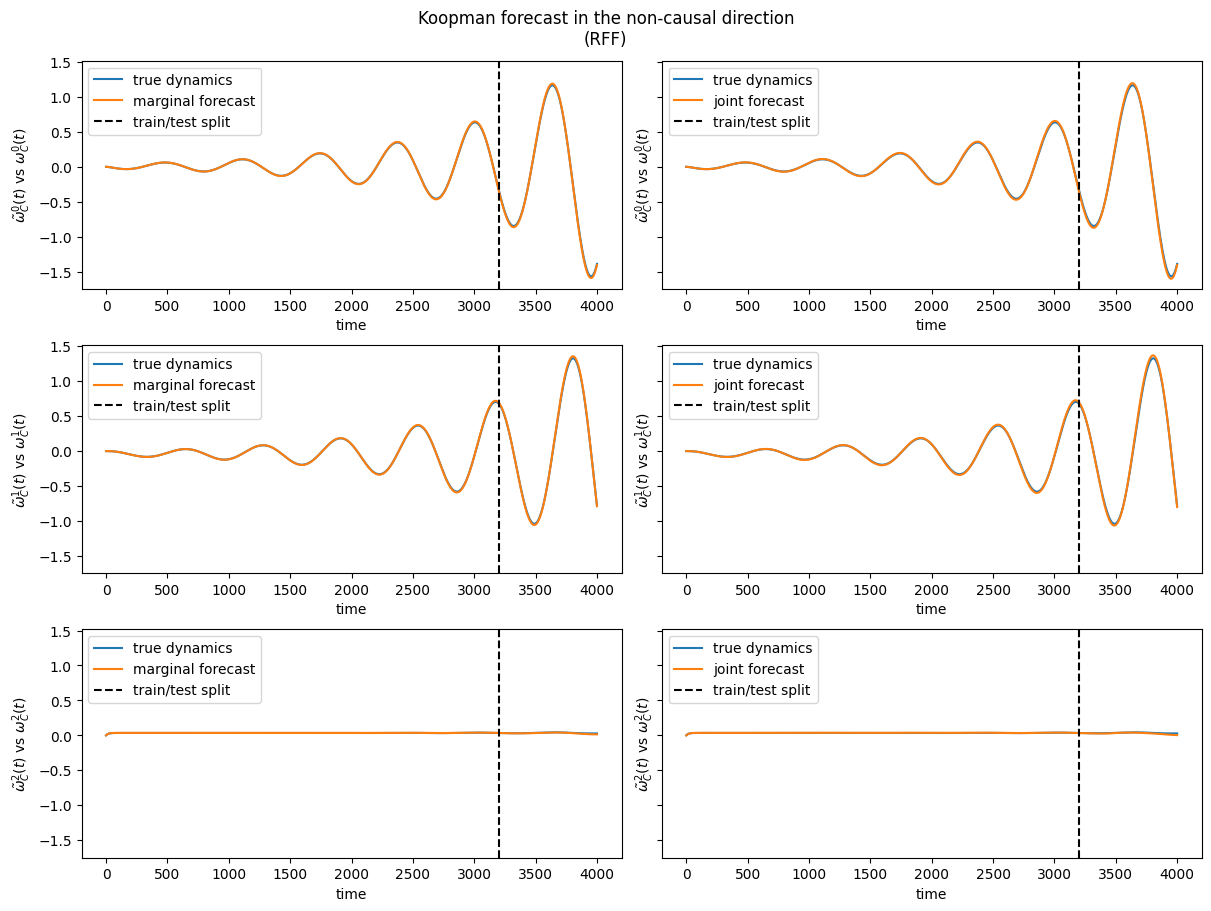

In [8]:
# Conditional inference (non-causal)
# Expected behavior: better match in both models.
cause = omega_1
effect = omega_2
n_train = int(0.8 * steps)

omega_marginal, omega_joint = conditional_forecasting(
    cause = cause, 
    effect = effect, 
    n_train = n_train, 
    t = 1
)

# Plot
f, ax = plt.subplots(len(effect), 2, figsize=(12, 3 * len(effect)), sharey=True, constrained_layout=True)

for param_id in range(effect.shape[0]):
    # Left subplot: marginal forecast
    ax[param_id, 0].plot(effect[param_id], label='true dynamics')
    ax[param_id, 0].plot(omega_marginal[param_id], label='marginal forecast')
    ax[param_id, 0].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 0].set_xlabel('time')
    ax[param_id, 0].set_ylabel(rf'$\tilde{{\omega}}_C^{{{param_id}}}(t)$ vs $\omega_C^{{{param_id}}}(t)$')
    ax[param_id, 0].legend()

    # Right subplot: joint forecast
    ax[param_id, 1].plot(effect[param_id], label='true dynamics')
    ax[param_id, 1].plot(omega_joint[param_id], label='joint forecast')
    ax[param_id, 1].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 1].set_xlabel('time')
    ax[param_id, 1].set_ylabel(rf'$\tilde{{\omega}}_C^{{{param_id}}}(t)$ vs $\omega_C^{{{param_id}}}(t)$')
    ax[param_id, 1].legend()

# Add title above all subplots
f.suptitle('Koopman forecast in the non-causal direction\n(RFF)')
plt.show();


# Deep Causal Koopman
Using neural network (encoder-decoder) to approximate the lifting operators, i.e., y(t) = f[x(t)], where x(t) is the high-dimensional non-linear states, and y(t) is the observables.

In [9]:
from kausal.observables import MLPFeatures

In [10]:
# Hyperparameters
hidden_channels = [16, 32]
lr = 1e-2
epochs = 500

# Utility function
transform_1d = lambda x: x.permute(1, 0) # Transform into MLP-compatible shape of (T, C)


In [11]:
# 1. Causal direction
## Dataset prep
cause = transform_1d(omega_2)
effect = transform_1d(omega_1)
effect_cause = torch.cat([effect, cause], axis=1)
n_train = int(0.8 * steps)

## Initialize models
marginal_model_ce = MLPFeatures(in_channels=3, hidden_channels=hidden_channels, out_channels=3)
joint_model_ce = MLPFeatures(in_channels=6, hidden_channels=hidden_channels, out_channels=3)

## Fit models
marginal_loss_ce = marginal_model_ce.fit(
    x = effect[:n_train], 
    y = effect[:n_train], 
    epochs = epochs,
    lr = lr,
    batch_size = n_train
)

joint_loss_ce = joint_model_ce.fit(
    x = effect_cause[:n_train], 
    y = effect[:n_train], 
    epochs = epochs,
    lr = lr,
    batch_size = n_train
)


100%|████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 39.23it/s]


In [12]:
# 2. Non-causal direction
## Dataset prep
cause = transform_1d(omega_1)
effect = transform_1d(omega_2)
effect_cause = torch.cat([effect, cause], axis=1)
n_train = int(0.8 * steps)

## Initialize models
marginal_model_ec = MLPFeatures(in_channels=3, hidden_channels=hidden_channels, out_channels=3)
joint_model_ec = MLPFeatures(in_channels=6, hidden_channels=hidden_channels, out_channels=3)

## Fit models
marginal_loss_ec = marginal_model_ec.fit(
    x = effect[:n_train], 
    y = effect[:n_train], 
    epochs = epochs,
    lr = lr,
    batch_size = n_train
)

joint_loss_ec = joint_model_ec.fit(
    x = effect_cause[:n_train], 
    y = effect[:n_train], 
    epochs = epochs,
    lr = lr,
    batch_size = n_train
)


100%|████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 39.32it/s]


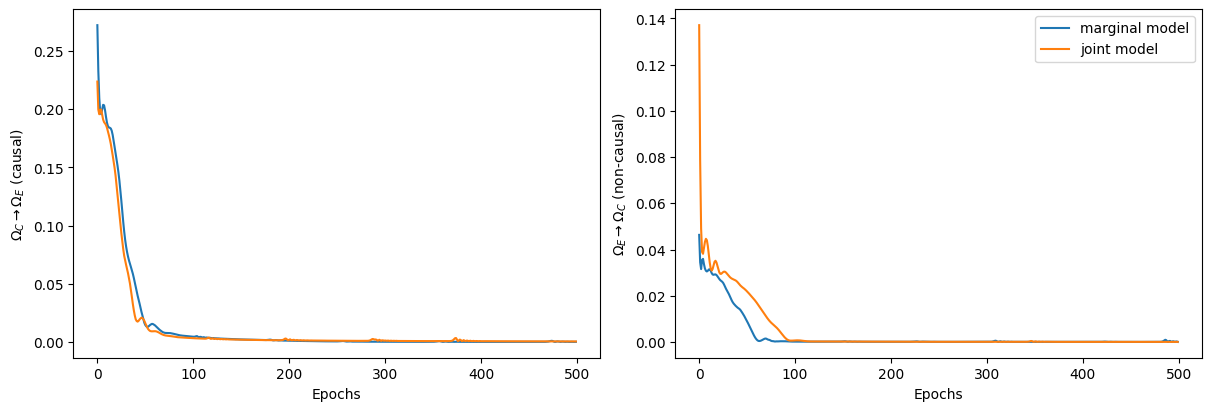

In [13]:
# Plot losses
f, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
ax[0].plot(marginal_loss_ce, label='marginal model')
ax[0].plot(joint_loss_ce, label='joint model')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

ax[1].plot(marginal_loss_ec, label='marginal model')
ax[1].plot(joint_loss_ec, label='joint model')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel(r'$\Omega_E \rightarrow \Omega_C$ (non-causal)')

plt.legend()
plt.show();


100%|██████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.45it/s]


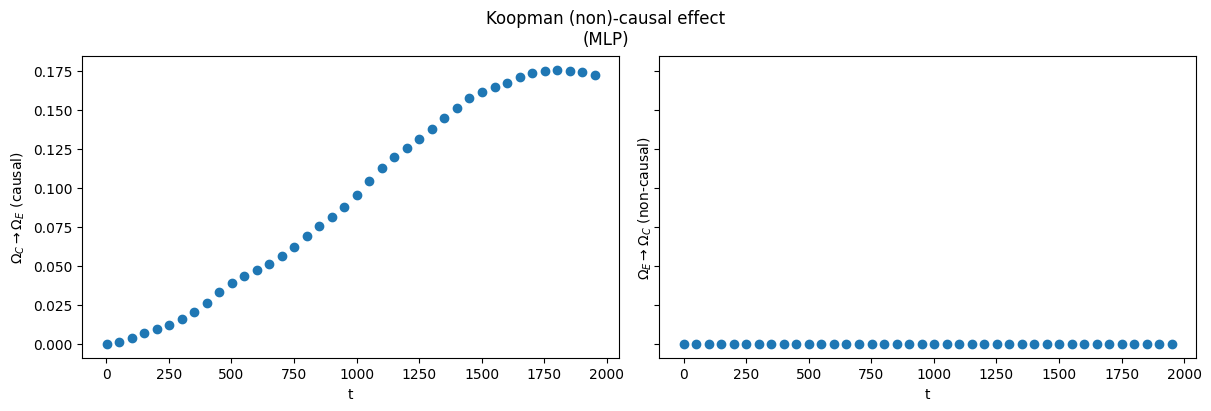

In [14]:
# Causal shifts
time_shifts = torch.arange(1, 2000, 50)
losses = {'causal': [], 'non_causal': []}

for t in tqdm(time_shifts):

    with torch.no_grad():

        ## 1. Causal loss
        causal_loss, _, _ = compute_causal_loss(
            cause = omega_2, 
            effect = omega_1,
            t = t,
            marginal_model = marginal_model_ce,
            joint_model = joint_model_ce
        )

        ## 2. Non-causal loss
        non_causal_loss, _, _ = compute_causal_loss(
            cause = omega_1, 
            effect = omega_2,
            t = t,
            marginal_model = marginal_model_ec,
            joint_model = joint_model_ec
        )
    
    losses['causal'].append(causal_loss)
    losses['non_causal'].append(non_causal_loss)

# Plot
f, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)
ax[0].scatter(time_shifts, losses['causal'])
ax[0].set_xlabel('t')
ax[0].set_ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

ax[1].scatter(time_shifts, losses['non_causal'])
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$\Omega_E \rightarrow \Omega_C$ (non-causal)')

f.suptitle('Koopman (non)-causal effect\n(MLP)')
plt.show();


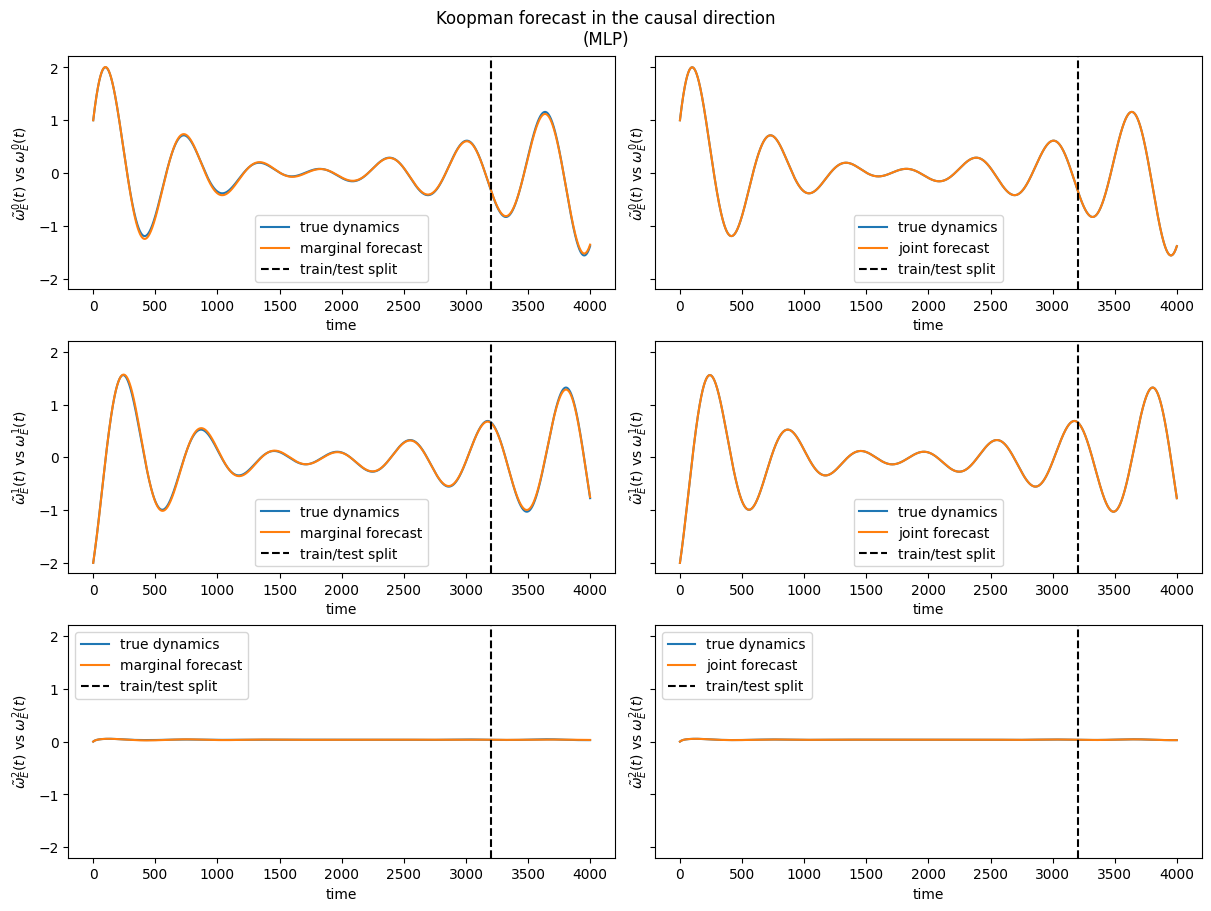

In [15]:
# Conditional inference (causal)
cause = omega_2
effect = omega_1

with torch.no_grad():
    omega_marginal, omega_joint = conditional_forecasting(
        cause = cause, 
        effect = effect, 
        t = 1,
        marginal_model = marginal_model_ce,
        joint_model = joint_model_ce
    )

# Plot
f, ax = plt.subplots(len(effect), 2, figsize=(12, 3 * len(effect)), sharey=True, constrained_layout=True)

for param_id in range(effect.shape[0]):
    # Left subplot: marginal forecast
    ax[param_id, 0].plot(effect[param_id], label='true dynamics')
    ax[param_id, 0].plot(omega_marginal[param_id], label='marginal forecast')
    ax[param_id, 0].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 0].set_xlabel('time')
    ax[param_id, 0].set_ylabel(rf'$\tilde{{\omega}}_E^{{{param_id}}}(t)$ vs $\omega_E^{{{param_id}}}(t)$')
    ax[param_id, 0].legend()

    # Right subplot: joint forecast
    ax[param_id, 1].plot(effect[param_id], label='true dynamics')
    ax[param_id, 1].plot(omega_joint[param_id], label='joint forecast')
    ax[param_id, 1].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 1].set_xlabel('time')
    ax[param_id, 1].set_ylabel(rf'$\tilde{{\omega}}_E^{{{param_id}}}(t)$ vs $\omega_E^{{{param_id}}}(t)$')
    ax[param_id, 1].legend()

# Add title above all subplots
f.suptitle('Koopman forecast in the causal direction\n(MLP)')
plt.show();


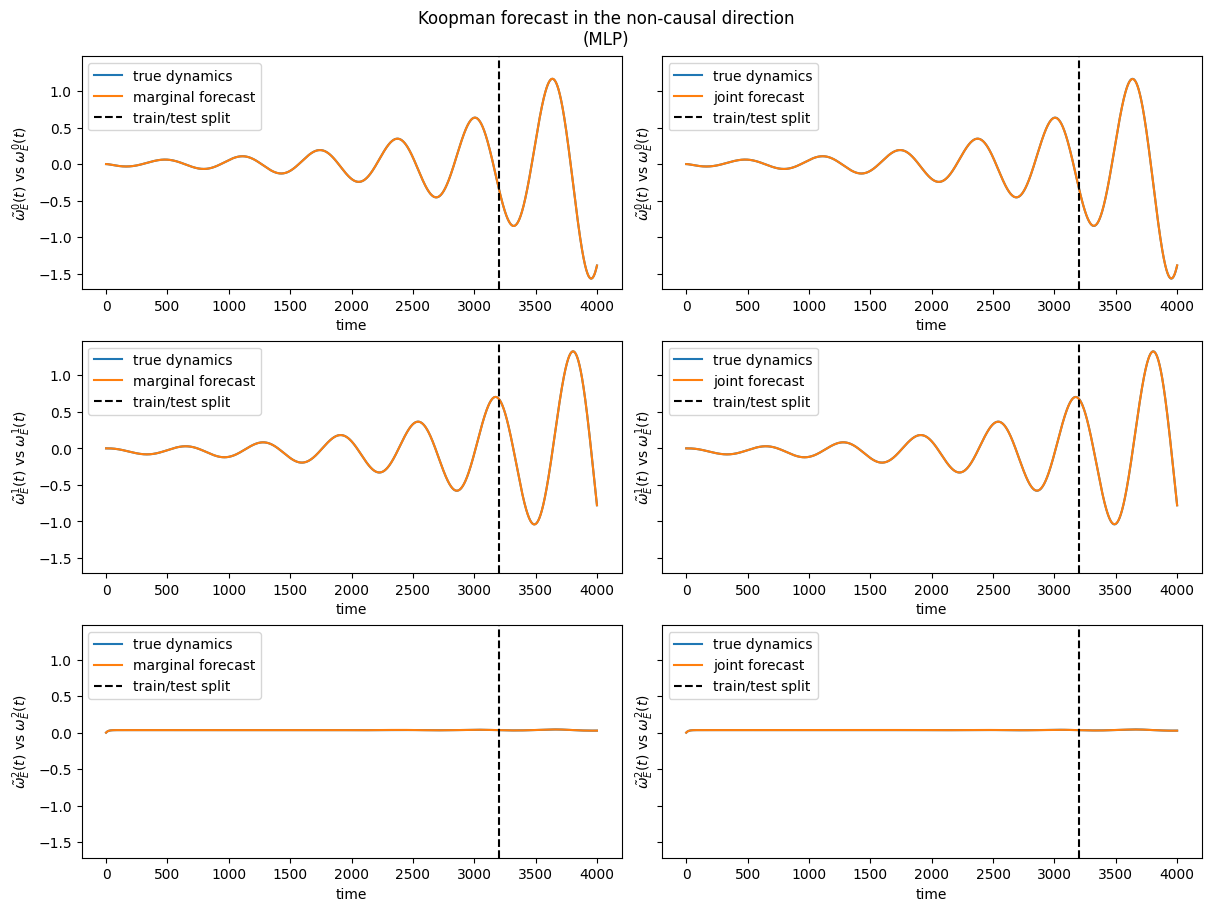

In [16]:
# Conditional inference (non-causal)
cause = omega_1
effect = omega_2

with torch.no_grad():
    omega_marginal, omega_joint = conditional_forecasting(
        cause = cause, 
        effect = effect, 
        t = 1,
        marginal_model = marginal_model_ec,
        joint_model = joint_model_ec
    )

# Plot
f, ax = plt.subplots(len(effect), 2, figsize=(12, 3 * len(effect)), sharey=True, constrained_layout=True)

for param_id in range(effect.shape[0]):
    # Left subplot: marginal forecast
    ax[param_id, 0].plot(effect[param_id], label='true dynamics')
    ax[param_id, 0].plot(omega_marginal[param_id], label='marginal forecast')
    ax[param_id, 0].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 0].set_xlabel('time')
    ax[param_id, 0].set_ylabel(rf'$\tilde{{\omega}}_E^{{{param_id}}}(t)$ vs $\omega_E^{{{param_id}}}(t)$')
    ax[param_id, 0].legend()

    # Right subplot: joint forecast
    ax[param_id, 1].plot(effect[param_id], label='true dynamics')
    ax[param_id, 1].plot(omega_joint[param_id], label='joint forecast')
    ax[param_id, 1].axvline(n_train, color='black', linestyle='--', label='train/test split') 
    ax[param_id, 1].set_xlabel('time')
    ax[param_id, 1].set_ylabel(rf'$\tilde{{\omega}}_E^{{{param_id}}}(t)$ vs $\omega_E^{{{param_id}}}(t)$')
    ax[param_id, 1].legend()

# Add title above all subplots
f.suptitle('Koopman forecast in the non-causal direction\n(MLP)')
plt.show();
